In [1]:
import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data

import math

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(2)
np.random.seed(2)

# правильно выбирайте карту, иначе все упадет!
CUDA_DEVICE=0

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    npimg = img.numpy().astype('uint8')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class CustomC100Dataset(data.Dataset):
    def __init__(self, dataset_path, dataset_type, img_cnt = 50000, transform = None, target_transform = None, indexes=None, valid_size=0):
        if dataset_type not in ['train', 'test', 'valid']:
            raise "Unknown dataset type : {}".format(dataset_type)
        self.ds_type = dataset_type
        self.ds_path = dataset_path
        self.img_cnt = img_cnt
        self.transform = transform
        self.t_transform = target_transform
        self.indexes = indexes
        self.valid_size = valid_size
        self.__load__()
    
    def __load__(self):
        dataset = np.load(self.ds_path)
        
        if self.ds_type == 'train' or self.ds_type == 'valid':
            dataset = dataset.reshape((self.img_cnt, 3073))
            self.y, self.x = np.hsplit(dataset, [1]) 
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
        
        if self.ds_type == 'train':
            self.y = self.y[self.indexes[self.valid_size:]]
            self.x = self.x[self.indexes[self.valid_size:]]
            self.mean = np.mean(self.x, axis=(0, 1, 2)) / 255.0
            self.std = np.std(self.x, axis=(0, 1, 2)) / 255.0
            self.transform.transforms.append(transforms.Normalize(self.mean, self.std))

        if self.ds_type == 'valid':
            self.y = self.y[self.indexes[:self.valid_size]]
            self.x = self.x[self.indexes[:self.valid_size]]    
        
        if self.ds_type == 'test':
            dataset = dataset.reshape((self.img_cnt,3072))
            self.y = np.zeros((dataset.shape[0], 1), dtype=np.int64)
            self.x = dataset.reshape((dataset.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
    
    def __getitem__(self, index):
        img, target = self.x[index], self.y[index]
        
        img = PIL.Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.t_transform is not None:
            target = self.t_transform(target)
            
        return img, target

    
    def __len__(self):
        return len(self.x)

In [29]:
IMG_TRAIN_CNT = 50000
IMG_TEST_CNT = 10000

valid_share = 0.2
valid_size = int(IMG_TRAIN_CNT * valid_share)
# индексы данных для отбора валидационных данных
indexes = list(range(IMG_TRAIN_CNT)) 
np.random.shuffle(indexes) 

In [3]:
transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
    # тут надо сделать аугментации и преобразования для trainset
    
])

transform_test = transforms.Compose([
                transforms.ToTensor(),
    # тут так же преобразования, но для testset
])

# подумайте, должны ли преобразования train и test сет быть абсолютно одинаковыми ?

train_dataset = CustomC100Dataset('homework_2.train.npy', 'train', img_cnt = IMG_TRAIN_CNT, 
                                  transform = transform_train, valid_size=valid_size, indexes=indexes)
# добавляю нормализацию для тестовых и валидационных данных на основе тренировочных данных
transform_test.transforms.append(train_dataset.transform.transforms[3])
valid_dataset = CustomC100Dataset('homework_2.train.npy', 'valid', img_cnt = IMG_TRAIN_CNT, 
                                  transform = transform_test, valid_size=valid_size, indexes=indexes)
test_nc_dataset = CustomC100Dataset('homework_2_no_classes.test.npy', 'test', img_cnt = IMG_TEST_CNT, 
                                    transform = transform_test)

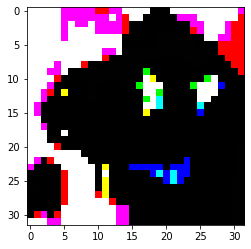

In [4]:
img, label = test_nc_dataset[0]
imshow(img)

In [5]:
class BasicBlock(nn.Module):
    expansion = 1 

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.downsample = downsample 
        self.stride = stride
        
        self.c1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  
        self.a1 = nn.ReLU(inplace=True)  
        self.c2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.a2 = nn.ReLU(inplace=True)  

    def forward(self, x):
        shortcut = x
        
        x = self.c1(x)
        x = self.bn1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            shortcut = self.downsample(shortcut)  
        x += shortcut
        x = self.a2(x) 

        return x

In [6]:
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BottleNeck, self).__init__()
        self.downsample = downsample 
        self.stride = stride

        self.c1 = nn.Conv2d(inplanes, planes , kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.a1 = nn.ReLU(inplace=True)  
        self.c2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.a2 = nn.ReLU(inplace=True)  
        self.c3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)  
        self.a3 = nn.ReLU(inplace=True)  
  

    def forward(self, x):
        shortcut = x
        
        x = self.c1(x)
        x = self.bn1(x)
        x = self.a1(x) 
        x = self.c2(x)
        x = self.bn2(x)
        x = self.a2(x) 
        x = self.c3(x)
        x = self.bn3(x) 
        if self.downsample is not None:
            shortcut = self.downsample(shortcut)     
        x += shortcut
        x = self.a3(x) 

        return x

In [7]:
# чтобы вы не запутались, сборку самой модели предоставляем
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, 
                               stride=1, padding=1, bias=False) # вставить сюда стартовую конволюцию из статьи
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0]) 
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8) 
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, mean=0, std=1)
                # написать инициализацию параметров конволюции
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.normal_(m.weight, mean=0, std=1)
                # инициализация параметров батч-нормализаций

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, 
                                    kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
                # здесь необходимо привести слои для downsampling в shotrcut соединениях
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
# Выбирайте любой ResNet

def ResNet20():
    return ResNet(BasicBlock, [3,3,3], 100)

def ResNet32():
    return ResNet(BasicBlock, [5,5,5], 100)

def ResNet44():
    return ResNet(BasicBlock, [7,7,7], 100)

def ResNet56():
    return ResNet(BottleNeck, [9,9,9], 100)

In [9]:
def validate(model, validation_loader, batch_size):
    model.eval()
    correct = 0.0
    total = 0.0
    valid_loss = 0
    criterion = nn.CrossEntropyLoss().cuda(CUDA_DEVICE)
    
    for batch_idx, (inputs, labels) in enumerate(validation_loader):
        inputs, labels = inputs.cuda(), labels.view(labels.shape[0]).cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        valid_loss += loss.data
        outputs = F.softmax(outputs, dim=1)
        prob, predicted = torch.topk(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.view(-1).eq(labels.data).sum()
        
    model.train()
    return (correct / total).cpu().item(), (valid_loss / len(validation_loader)).cpu().item()

In [10]:
def make_solution_pytorch(model, test_data_loader, batch_size):
    res = []
    model.eval()
    for batch_idx, (inputs, labels) in enumerate(test_data_loader):
        inputs, labels = inputs.cuda(), labels.view(labels.shape[0]).cuda()
        outputs = model(inputs)
        outputs = F.softmax(outputs, dim=1)
        prob, predicted = torch.topk(outputs.data, 1)
        res = np.append(res, predicted.view(-1).cpu().numpy())
    model.train()
    return res

In [11]:
#Обучение ResNet
#Не забудьте вывести графики accuracy (можно использовать acc_check()) и loss при обучении

model = ResNet56()
model.cuda(CUDA_DEVICE)

#all parameters from https://arxiv.org/pdf/1512.03385.pdf
epochs_cnt = 65000 # кол-во эпох

# эти параметры тоже на ваше усмотрение
minibatch_size = 64 
valid_batch_size = 32
test_batch_size = 64
lr = 0.1

ACC_TO_STOP = 0.68

optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, 
                            momentum=0.9, weight_decay=0.0001) # выбираем отимизатор 
lr_optim = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60, 100], gamma=0.1)
criterion = nn.CrossEntropyLoss().cuda(CUDA_DEVICE)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = minibatch_size, 
                                           shuffle = True, num_workers = 4, drop_last = False) 
test_nc_loader = torch.utils.data.DataLoader(test_nc_dataset, batch_size = test_batch_size, 
                                             shuffle = False, num_workers = 4, drop_last = False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = valid_batch_size, 
                                          shuffle = False, num_workers = 4, drop_last = False)

train_losses = []
valid_losses = []
accuracy_valid = []

# примерный код для обучения модели, не обязательно строго следовать ему
for epoch in range(epochs_cnt):  
    train_loss = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.view(labels.shape[0]).cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        train_loss += loss.data
        loss.backward()
        optimizer.step()
        
    train_losses.append((train_loss / len(train_loader)).cpu().item())
    accuracy, valid_loss = validate(model, valid_loader, valid_batch_size)
    accuracy_valid.append(accuracy)
    valid_losses.append(valid_loss)
    print(f'[{epoch}] accuraccy: {accuracy_valid[-1]}')
    
    lr_optim.step()
    
    if accuracy_valid[-1] >= ACC_TO_STOP:
        break

print('Finished Training')

[0] accuraccy: 0.017999999225139618
[1] accuraccy: 0.033799998462200165
[2] accuraccy: 0.06079999729990959
[3] accuraccy: 0.08859999477863312
[4] accuraccy: 0.10799999535083771
[5] accuraccy: 0.1306999921798706
[6] accuraccy: 0.16329999268054962
[7] accuraccy: 0.17839999496936798
[8] accuraccy: 0.19900000095367432
[9] accuraccy: 0.2505999803543091
[10] accuraccy: 0.2797999978065491
[11] accuraccy: 0.2883000075817108
[12] accuraccy: 0.31029999256134033
[13] accuraccy: 0.32889997959136963
[14] accuraccy: 0.35169997811317444
[15] accuraccy: 0.3700999915599823
[16] accuraccy: 0.36479997634887695
[17] accuraccy: 0.3962000012397766
[18] accuraccy: 0.4226999878883362
[19] accuraccy: 0.4355999827384949
[20] accuraccy: 0.4226999878883362
[21] accuraccy: 0.4343999922275543
[22] accuraccy: 0.42719998955726624
[23] accuraccy: 0.4553000032901764
[24] accuraccy: 0.4607999920845032
[25] accuraccy: 0.43369999527931213
[26] accuraccy: 0.4912000000476837
[27] accuraccy: 0.43549999594688416
[28] accuracc

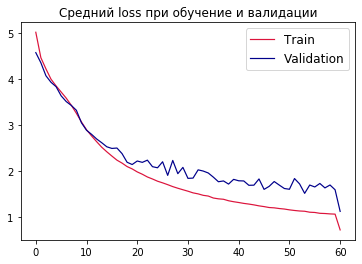

In [27]:
plt.title("Средний loss при обучение и валидации")
plt.plot(train_losses, "crimson", linewidth=1.2, label="Train")
plt.plot(valid_losses, "darkblue", linewidth=1.2, label="Validation")
plt.legend(loc="upper right", fontsize=12)
plt.show()

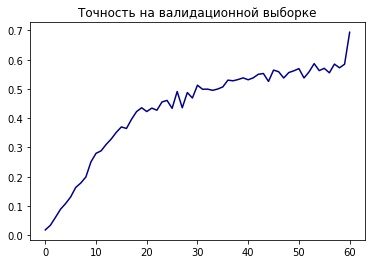

In [28]:
plt.title("Точность на валидационной выборке")
plt.plot(accuracy_valid, "darkblue")
plt.show()

In [14]:
# генерим решение вашей модели
solution = make_solution_pytorch(model, test_nc_loader, test_batch_size)
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(solution):
        print(i, int(prediction), sep=',', file=fout)